<a href="https://colab.research.google.com/github/Ebhibhebhi/image_classifiers/blob/main/finetuning_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Kaggle dataset

!unzip -q "/content/archive.zip" -d "/content/archive"

In [2]:
!ls /content/archive

Fish-vs-Cats


# Removing corrupted files

In [3]:
import os
from PIL import Image

ROOT = "/content/archive/Fish-vs-Cats"
splits = ["train", "val", "test"]
classes = ["cat", "fish"]

bad_files = []

# 1) Scan and collect bad images
for split in splits:
    for cls in classes:
        folder = os.path.join(ROOT, split, cls)
        for fname in os.listdir(folder):
            path = os.path.join(folder, fname)
            try:
                with Image.open(path) as img:
                    img.verify()  # checks image integrity
            except Exception:
                bad_files.append(path)

# 2) Remove bad images
for path in bad_files:
    os.remove(path)

print(f"Removed {len(bad_files)} corrupted images.\n")

# 3) Count remaining images
print("Final dataset counts:")
total = 0
for split in splits:
    split_total = 0
    print(f"\n{split.upper()}:")
    for cls in classes:
        folder = os.path.join(ROOT, split, cls)
        count = len([
            f for f in os.listdir(folder)
            if os.path.isfile(os.path.join(folder, f))
        ])
        split_total += count
        print(f"  {cls}: {count}")
    total += split_total
    print(f"  TOTAL: {split_total}")

print(f"\nOVERALL TOTAL IMAGES: {total}")

Removed 19 corrupted images.

Final dataset counts:

TRAIN:
  cat: 417
  fish: 384
  TOTAL: 801

VAL:
  cat: 87
  fish: 22
  TOTAL: 109

TEST:
  cat: 91
  fish: 69
  TOTAL: 160

OVERALL TOTAL IMAGES: 1070


# Balancing data

In [4]:
import os
import random

ROOT = "/content/archive/Fish-vs-Cats"
splits = ["train", "val", "test"]
classes = ["cat", "fish"]

SEED = 42
DRY_RUN = False  # set to False to actually delete files

random.seed(SEED)

def list_files(folder):
    return [
        f for f in os.listdir(folder)
        if os.path.isfile(os.path.join(folder, f))
    ]

def count_split(split):
    counts = {}
    for cls in classes:
        folder = os.path.join(ROOT, split, cls)
        counts[cls] = len(list_files(folder))
    return counts

print("BEFORE BALANCING:")
before_counts = {}
for split in splits:
    c = count_split(split)
    before_counts[split] = c
    print(f"{split.upper()}: cat={c['cat']} fish={c['fish']} total={c['cat'] + c['fish']}")

print("\nBALANCING PLAN (undersample to the min per split):")
to_delete = []

for split in splits:
    split_counts = before_counts[split]
    target = min(split_counts["cat"], split_counts["fish"])
    print(f"\n{split.upper()}: target per class = {target}")

    for cls in classes:
        folder = os.path.join(ROOT, split, cls)
        files = list_files(folder)
        extra = len(files) - target

        if extra > 0:
            # randomly pick extra files to delete
            delete_files = random.sample(files, extra)
            delete_paths = [os.path.join(folder, f) for f in delete_files]
            to_delete.extend(delete_paths)
            print(f"  {cls}: deleting {extra} files")
        else:
            print(f"  {cls}: deleting 0 files")

print(f"\nTOTAL FILES MARKED FOR DELETION: {len(to_delete)}")

if DRY_RUN:
    print("\nDRY_RUN=True so nothing was deleted.")
    print("If this looks right, set DRY_RUN=False and rerun.")
else:
    deleted = 0
    for path in to_delete:
        if os.path.exists(path):
            os.remove(path)
            deleted += 1
    print(f"\nDeleted {deleted} files.")

    print("\nAFTER BALANCING:")
    total_after = 0
    for split in splits:
        c = count_split(split)
        total_after += c["cat"] + c["fish"]
        print(f"{split.upper()}: cat={c['cat']} fish={c['fish']} total={c['cat'] + c['fish']}")
    print(f"\nOVERALL TOTAL IMAGES AFTER: {total_after}")

BEFORE BALANCING:
TRAIN: cat=417 fish=384 total=801
VAL: cat=87 fish=22 total=109
TEST: cat=91 fish=69 total=160

BALANCING PLAN (undersample to the min per split):

TRAIN: target per class = 384
  cat: deleting 33 files
  fish: deleting 0 files

VAL: target per class = 22
  cat: deleting 65 files
  fish: deleting 0 files

TEST: target per class = 69
  cat: deleting 22 files
  fish: deleting 0 files

TOTAL FILES MARKED FOR DELETION: 120

Deleted 120 files.

AFTER BALANCING:
TRAIN: cat=384 fish=384 total=768
VAL: cat=22 fish=22 total=44
TEST: cat=69 fish=69 total=138

OVERALL TOTAL IMAGES AFTER: 950


# **Preparing Datasets**

In [5]:
import torchvision
from torchvision import transforms

ROOT = "/content/archive/Fish-vs-Cats"

# Setting up training data
train_data_path = f"{ROOT}/train"

# what transform does is exactly what it sounds like, it is a machine that applies transformations to image data
# When defining the object, you're basically choosing what transformations you want to apply to the data
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])
# Here you are now actually creating the transformed dataset
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)

# Setting up validation data (compare accuracy against this set after each epoch)

val_data_path = f"{ROOT}/val"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=transform)

# Setting up test data
test_data_path = f"{ROOT}/test"
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)

# **Data Loaders**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

In [7]:
from torch.utils.data import DataLoader

batch_size = 64
# These dataloaders will pass the data into our neural network
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size)

# **Resnet**

In [17]:
from torchvision import models

transfer_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [18]:
# Don't freeze the batch normalization layers because they are trained to approximate the mean and sd of the dataset the model was originally trained on
# So therefore u might lose some signal in your data as it tries to correct it.

for name, param in transfer_model.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

In [19]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 500),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(500, 2))

# in_features tells us the number of activations coming into the layer we are editing
# out_features tells us the number of activations coming out

# **Optimizer**

In [20]:
# optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)
optimizer = optim.Adam([
    {'params': transfer_model.layer4.parameters(), 'lr': 0.01/3},
    {'params': transfer_model.layer3.parameters(), 'lr': 0.01/9}
    ], lr = 0.01)
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]

for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

# **Find Optimal Learning Rate**

In [ ]:
import math
import matplotlib.pyplot as plt

def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0):
    model = model.to(device)
    model.train()

    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        loss_val = loss.item()

        if batch_num > 1 and loss_val > 4 * best_loss:
            return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss_val

        # Store the values

        losses.append(loss.item())
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs, losses

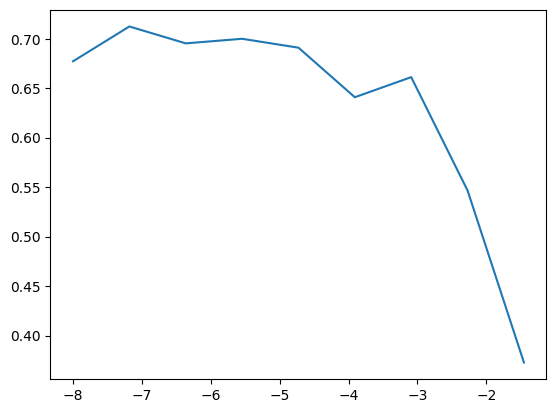

In [ ]:
log, losses = find_lr(transfer_model,
                      torch.nn.CrossEntropyLoss(),
                      optim.Adam(transfer_model.parameters(), lr=0.0001),
                      train_data_loader)
plt.plot(log, losses)
plt.show()

found_lr = 0.01

# **Training**

In [21]:
from torch._higher_order_ops import out_dtype
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

transfer_model.to(device)

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, target = batch
            inputs = inputs.to(device)
            output = model(inputs)
            target = target.to(device)
            loss = loss_fn(output, target)
            valid_loss += loss.data.item() *  inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)

            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}".format(epoch, training_loss, valid_loss, num_correct / num_examples))

In [22]:
train(transfer_model,
      optimizer,
      torch.nn.CrossEntropyLoss(),
      train_data_loader,
      val_data_loader,
      epochs=25,
      device=device)

/tmp/ipython-input-3909263327.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)


Epoch: 1, Training Loss: 0.35, Validation Loss: 0.15, accuracy = 0.98
Epoch: 2, Training Loss: 0.12, Validation Loss: 0.37, accuracy = 0.98
Epoch: 3, Training Loss: 0.03, Validation Loss: 0.26, accuracy = 0.93
Epoch: 4, Training Loss: 0.03, Validation Loss: 0.11, accuracy = 0.98
Epoch: 5, Training Loss: 0.02, Validation Loss: 0.10, accuracy = 0.95
Epoch: 6, Training Loss: 0.02, Validation Loss: 0.25, accuracy = 0.93
Epoch: 7, Training Loss: 0.01, Validation Loss: 0.11, accuracy = 0.98
Epoch: 8, Training Loss: 0.01, Validation Loss: 0.16, accuracy = 0.98
Epoch: 9, Training Loss: 0.03, Validation Loss: 0.17, accuracy = 0.95
Epoch: 10, Training Loss: 0.02, Validation Loss: 0.31, accuracy = 0.91
Epoch: 11, Training Loss: 0.01, Validation Loss: 0.17, accuracy = 0.98
Epoch: 12, Training Loss: 0.00, Validation Loss: 0.01, accuracy = 1.00
Epoch: 13, Training Loss: 0.00, Validation Loss: 0.09, accuracy = 0.98
Epoch: 14, Training Loss: 0.02, Validation Loss: 0.26, accuracy = 0.95
Epoch: 15, Trai

# **Making Predictions**

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import random

def predict_random_test_image(model, test_dir, transform, labels, device):
  model.eval()

  # pick random class folder
  class_name = random.choice(os.listdir(test_dir))
  class_dir = os.path.join(test_dir, class_name)

  # pick random image
  img_name = random.choice(os.listdir(class_dir))
  img_path = os.path.join(class_dir, img_name)

  # load image
  img = Image.open(img_path).convert('RGB')

  # display image
  plt.imshow(img)
  plt.axis("off")

  # prepare for model
  img_tensor = transform(img).unsqueeze(0).to(device)

  # inference

  with torch.no_grad():
    logits = model(img_tensor)
    probs = torch.softmax(logits, dim=1)
    pred_idx = probs.argmax(dim=1).item()
    confidence = probs[0][pred_idx].item()

  pred_label = labels[pred_idx]

  plt.title(f"Model prediction: {pred_label} ({confidence:.2%})")
  plt.show()

  print(f"True class: {class_name}")
  print(f"Predicted class: {pred_label}")


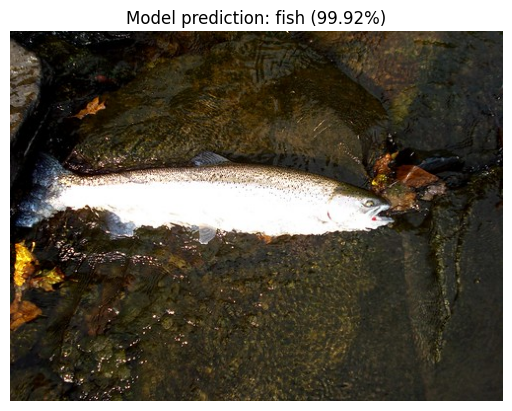

True class: fish
Predicted class: fish


In [31]:
labels = ['cat', 'fish']
test_dir = "/content/archive/Fish-vs-Cats/test"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predict_random_test_image(transfer_model, test_dir, transform, labels, device)

# **Saving the model**

In [ ]:
# Saving the model in pickle format:
# torch.save(simplenet, "/tmp/simplenet")

# and we can reload the model as:
# simplenet = torch.load("/tmp/simplenet")

# This stores both the parameters and the structure of the model to a file, but this may be a problem
# if you change the structure of the model at a later time

# For this reason it's more common to save a model's state_dict instead, which is a standard Python dict
# which contains the maps of each layers parameters in the model:

# torch.save(model.state_dict(), PATH)

# To restore, create an instance of the model and then use load_state_dict

# simplenet = SimpleNet()
# simplenet_state_dict = torch.load("/tmp/simplenet")
# simplenet.load_state_dict(simplenet_state_dict)